In [1]:
import os
os.environ['HSA_OVERRIDE_GFX_VERSION'] = '10.3.0'

# basic modules
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import chi2_contingency
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

Read the data.

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_rows', 500)

data_path = './data/'
train = 'train.csv'

train_file = os.path.join(data_path,train)

In [3]:
df = pd.read_csv(train_file)

EDA.

In [4]:
print(df.info())

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
None


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


**Engineer 'PassengerId' column**:
- The 'PassengerId' column is of the form: gggg_pp where gggg indicates the group they are traveling with and pp is their number within the group. By extracting these values we can create meaning from this column and hopefully use it to impute missing values later.

In [5]:
df['GroupId'] = df['PassengerId'].apply(lambda x: x.split("_")[0]).astype(int)
df['PersonId'] = df['PassengerId'].apply(lambda x: x.split("_")[1]).astype(int)
df.drop(columns=['PassengerId'], inplace=True)

**Engineer the 'Cabin' column:**
- The 'Cabin' column is of the form deck/num/side. We can engineer this feature to extract meaningful info for the column.

In [6]:
df['Deck'] = df[df['Cabin'].notna()]['Cabin'].str.split('/').apply(lambda x: x[0])
df['Num'] = df[df['Cabin'].notna()]['Cabin'].str.split('/').apply(lambda x: x[1])
df['Side'] = df[df['Cabin'].notna()]['Cabin'].str.split('/').apply(lambda x: x[2])
df.drop(columns=['Cabin'],inplace=True)

**Extract the last names**

In [7]:
df['FirstName'] = df[df['Name'].notna()]['Name'].str.split(' ').apply(lambda x: x[0].strip())
df['LastName'] = df[df['Name'].notna()]['Name'].str.split(' ').apply(lambda x: x[1].strip())
df.drop(columns=['Name'], inplace = True)

### Imputation of missing home planets.
***I need to determine if I should proceed with imputation of HomePlanet and Destination fields. These values might not be MCAR:***

In [8]:
contingency = pd.crosstab(df['HomePlanet'], df['Transported'], dropna=False)

print(contingency)

c, p, dof, expected = chi2_contingency(contingency)

print(c,p,dof)
print(expected)

Transported  False  True 
HomePlanet               
Earth         2651   1951
Europa         727   1404
Mars           839    920
NaN             98    103
324.96723663979583 3.9214919240932375e-70 3
[[2284.32416887 2317.67583113]
 [1057.77809732 1073.22190268]
 [ 873.12607845  885.87392155]
 [  99.77165535  101.22834465]]


Observation
- We can see that the frequency table for the missing home planet and the chi-2 expected frequency values are nearly the same, which indicates that there isn't an apparent association between a home planet being missing and being successfully transported or not. This hints at homeplanet being missing being an MCAR value, which means we will proceed with imputation of this feature.

### Impute missing home planets (High-Confidence) (Family members)
Missing home planet will be imputed for groups of people such that:
- They all have the same GroupID
- All have the same LastName
- All come from the same planet
- All going to the same destination

The home planet imputed will be the groups home planet

In [9]:
def get_groups_0(df) -> list:
  groups = []
  group_ids = df['GroupId'].unique().tolist()
  for group_id in group_ids:

    # get sub-dataframe based off of group id
    group_df = df[df['GroupId'] == group_id]

    has_missing_planet = group_df['HomePlanet'].isna().any()
    has_one_distinct_home = group_df['HomePlanet'].dropna().nunique() == 1
    has_one_distinct_destination = group_df['Destination'].dropna().nunique() == 1
    has_one_distinct_last_name = group_df['LastName'].dropna().nunique() == 1
    
    if (
        has_missing_planet and
        has_one_distinct_last_name and
        has_one_distinct_home and
        has_one_distinct_destination        
    ):
        groups.append(group_df)
      
  return groups

group_dfs = get_groups_0(df)
print(f"number of samples where home planet is missing:{df['HomePlanet'].isna().sum()}")
print(f"Number of groups: {len(group_dfs)}")

while group_dfs:
  group_df = group_dfs.pop()
  home_planets = group_df['HomePlanet'].dropna().unique()
  if len(home_planets) > 1:
    raise ValueError(home_planets)
  home_planet = home_planets[0]
  df.loc[group_df['HomePlanet'].isna().index, 'HomePlanet'] = home_planet
  
print(f"number of samples where home planet is missing:{df['HomePlanet'].isna().sum()}")

number of samples where home planet is missing:201
Number of groups: 36
number of samples where home planet is missing:165


### Impute missing home planets (Medium Confidence) (Family members from same planet)
**Imput Home Planets by:**
  - Groups where GroupID are all the same
  - Groups where LastName are all the same
  - There is only one unique type of home planet in the group of people
  
Update missing home planets with the groups single distinct non-na home planet

In [10]:
def get_groups_1(df):
    groups =[]
    group_ids = df['GroupId'].unique().tolist()
    for group_id in group_ids:
        group_df = df[df['GroupId'] == group_id]
        
        missing_home_planet = group_df['HomePlanet'].isna().any()
        one_distinct_last_name = group_df['LastName'].dropna().nunique() == 1
        one_distinct_home_planet = group_df['HomePlanet'].dropna().nunique() == 1
        
        if (
            missing_home_planet and
            one_distinct_last_name and
            one_distinct_home_planet
        ):
            groups.append(group_df)
            
    return groups

group_dfs = get_groups_1(df)

print(f"number of samples with missing home planet: {df['HomePlanet'].isna().sum()}")
print("groups:",len(group_dfs))

while group_dfs:
    group_df = group_dfs.pop()
    
    planets = group_df['HomePlanet'].dropna().unique().tolist()
    
    if len(planets) != 1:
        raise ValueError("HUH")

    df.loc[group_df['HomePlanet'].isna().index, 'HomePlanet'] = planets[0]    
    
print(f'samples remaining with missing home planets: {df["HomePlanet"].isna().sum()}')

number of samples with missing home planet: 165
groups: 31
samples remaining with missing home planets: 133


### Imputation of missing destination planets

Same process as before

In [11]:
contingency = pd.crosstab(df['Destination'], df['Transported'], dropna=False)

print(contingency)

c, p, dof, expected = chi2_contingency(contingency)

print(c,p,dof)
print(expected)

Transported    False  True 
Destination                
55 Cancri e      702   1098
PSO J318.5-22    395    401
TRAPPIST-1e     3128   2787
NaN               90     92
106.39488238823832 6.547434028958798e-23 3
[[ 893.47751064  906.52248936]
 [ 395.11561026  400.88438974]
 [2936.06637524 2978.93362476]
 [  90.34050385   91.65949615]]


Obvservation:
- Similar case as the home planetplanet feature. These missing destination planets appear to be MCAR due to the low assocation. We will impute the missing values.

Action
- For Groups of GroupId such that:
    - There is at least one person in the group with a missing destination planet
    - All people in the group have the same last name (family)
    - ALl people in the group have the same home planet
    - ALl people in the group have the same destination (excluding the missing destinations)
Fill the missing destination

In [12]:
def get_group_2(df):
  groups = []
  group_ids = df['GroupId'].unique().tolist()
    
  for group_id in group_ids:
    
    group_df = df[df['GroupId'] == group_id]
    
    at_least_one_missing_destination_planet = group_df['Destination'].isna().any()
    only_one_distinct_destination_planet = group_df['Destination'].dropna().nunique() == 1    
    only_one_distinct_home_planet = group_df['HomePlanet'].dropna().nunique() == 1
    only_one_distinct_last_name = group_df['LastName'].dropna().nunique() == 1
    
    if (
        at_least_one_missing_destination_planet and
        only_one_distinct_home_planet and
        only_one_distinct_destination_planet and
        only_one_distinct_last_name
    ):
        groups.append(group_df)
    
  return groups

print('number of remaining samples where destination is missing:',df['Destination'].isna().sum())

groups = get_group_2(df)
print(f'number of groups found: {len(groups)}')

while groups:
    group_df = groups.pop()
    destination_planets = group_df['Destination'].dropna().unique().tolist()
    if len(destination_planets) != 1:
        raise ValueError(len(destination_planets))
    df.loc[group_df['Destination'].isna().index, 'Destination'] = destination_planets[0]
    
print('number of remaining samples where destination is missing after imputation:',df['Destination'].isna().sum())


number of remaining samples where destination is missing: 182
number of groups found: 48
number of remaining samples where destination is missing after imputation: 134


### Feature Importance and Further imputation
To determine which categorical features to impute next, lets attempt to rank our categorical features importance with respect to the target using regression.

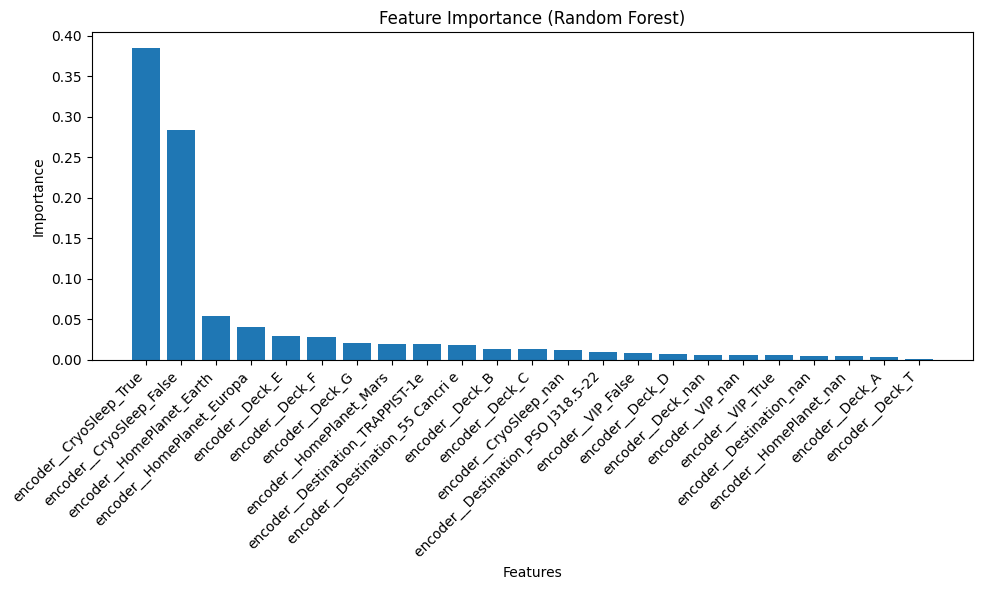

In [13]:
# Assuming your data is in a DataFrame called 'df'
categorical_features = ['HomePlanet', 'Destination', 'VIP', 'CryoSleep', 'Deck']  # Replace with your categorical feature names
target_feature = 'Transported'  # Replace with the name of your target variable

# Separate the features and target
X = df[categorical_features]
y = df[target_feature]

# Perform one-hot encoding on the categorical features
ct = ColumnTransformer([
    ('encoder', OneHotEncoder(), categorical_features)],
     remainder='passthrough')
X_encoded = ct.fit_transform(X)

# Train a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_encoded, y)

# Get the feature importance scores
feature_importance = rf_classifier.feature_importances_

# Create a DataFrame with feature names and their importance scores
feature_names = ct.get_feature_names_out()
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Sort the features by importance in descending order
importance_df = importance_df.sort_values('Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance (Random Forest)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Observations:
- We can see that someone doing cryosleep or not has a large impact on if they were transported or not. This will be the feature we will try to tackle next.

### Try to start working on the Cryosleep column
Let's see what we can gleen from cryosleep to try and impute it

  HomePlanet  Destination   Age    VIP  RoomService  FoodCourt  ShoppingMall     Spa  VRDeck  Transported  GroupId  PersonId Deck Num Side FirstName     LastName  CryoSleep_True
0     Europa  TRAPPIST-1e  39.0  False          0.0        0.0           0.0     0.0     0.0        False        1         1    B   0    P     Maham    Ofracculy           False
1      Earth  TRAPPIST-1e  24.0  False        109.0        9.0          25.0   549.0    44.0         True        2         1    F   0    S    Juanna        Vines           False
2     Europa  TRAPPIST-1e  58.0   True         43.0     3576.0           0.0  6715.0    49.0        False        3         1    A   0    S    Altark       Susent           False
3     Europa  TRAPPIST-1e  33.0  False          0.0     1283.0         371.0  3329.0   193.0        False        3         2    A   0    S     Solam       Susent           False
4      Earth  TRAPPIST-1e  16.0  False        303.0       70.0         151.0   565.0     2.0         True     

/home/lucas/Code/kaggle-challenges/venv/lib/python3.10/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


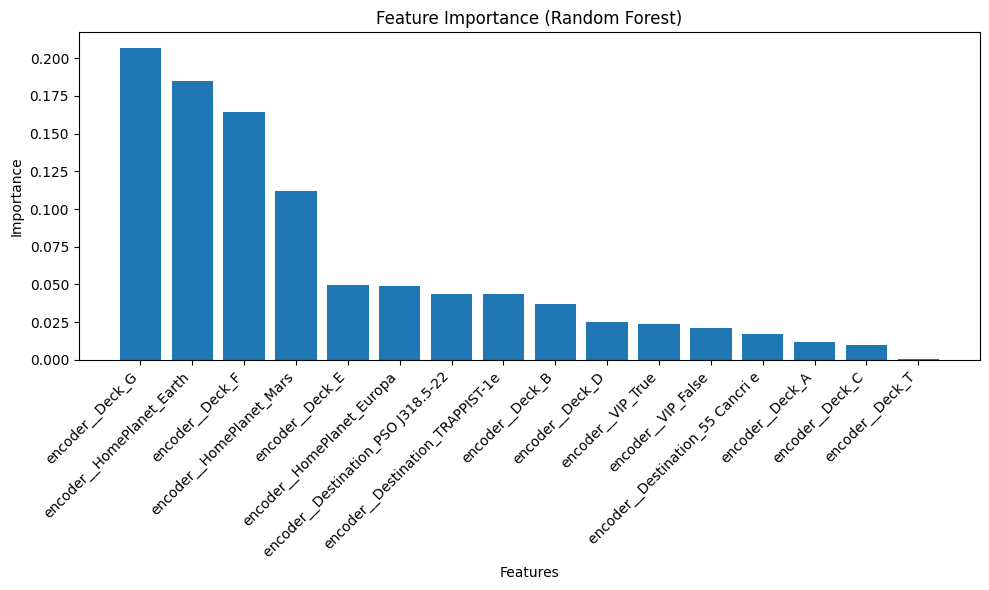

In [24]:
# Assuming your data is in a DataFrame called 'df'
categorical_features = ['HomePlanet', 'Destination', 'VIP', 'Deck']  # Replace with your categorical feature names
target_feature = 'CryoSleep'  # Replace with the name of your target variable

dff = df.dropna()

dff = pd.get_dummies(dff, columns=['CryoSleep'], drop_first=True)
print(dff.head())

# Separate the features and target
X = dff[categorical_features]
y = dff[['CryoSleep_True']]

print(y.isna().sum())

# Perform one-hot encoding on the categorical features
ct = ColumnTransformer([
    ('encoder', OneHotEncoder(), categorical_features)],
     remainder='passthrough')
X_encoded = ct.fit_transform(X)

# Train a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_encoded, y)

# Get the feature importance scores
feature_importance = rf_classifier.feature_importances_

# Create a DataFrame with feature names and their importance scores
feature_names = ct.get_feature_names_out()
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Sort the features by importance in descending order
importance_df = importance_df.sort_values('Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance (Random Forest)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Observation**
- There appears to be an extremely high correlation between cryosleep and transported. That is, it is not random. We should try from here to impute missing Cryosleep fields

### Analyze cryosleep

***Planted-based:***

In [ ]:
contingency = pd.crosstab(df['HomePlanet'], df['CryoSleep'], dropna=True)

display(contingency)

chi, p, d, freq = chi2_contingency(contingency)
display(chi,p,d)
display(freq)

**Observation**:
- There is an association between if someone does cryosleep and the planet they are from.

In [ ]:
spend_money_cols = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']

display("DID CRYO")
did_cryo = df[df['CryoSleep'] == True]
display(did_cryo.head())
display(did_cryo[spend_money_cols].describe())

display("------------------")
display("NO CRYO")
no_cryo = df[df['CryoSleep'] == False]
display(no_cryo.head())
display(no_cryo[spend_money_cols].describe())

**Observation**
- We can see that spending is a good predictor of if someone did cryosleep or not. People who do cryosleep don't spend any money.

Lets see what other information might point to if someone did cryosleep or not.

***Planet and Cryosleep***

In [ ]:
# Assuming your data is in a DataFrame called 'df'
# Replace 'categorical_feature' with the name of the categorical feature you want to visualize

sns.countplot(x='HomePlanet', hue='CryoSleep', data=df)
plt.xlabel('Planets')
plt.ylabel('Count')
plt.title('Association between Planet and CryoSleep')
plt.show()

sns.countplot(x='Destination', hue='CryoSleep', data=df)
plt.xlabel('Categorical Feature')
plt.ylabel('Count')
plt.title('Association between Categorical Feature and CryoSleep')
plt.show()

df_earth_cryo = df[(df['HomePlanet'] == 'Earth')]
proportions = pd.crosstab(df_earth_cryo['Destination'], df_earth_cryo['CryoSleep'], normalize='index')
plt.xlabel('From Earth')
plt.ylabel('Proportion')
proportions.plot(kind='bar', stacked=True)

df_mars_cryo = df[(df['HomePlanet'] == 'Mars')]
proportions = pd.crosstab(df_mars_cryo['Destination'], df_mars_cryo['CryoSleep'], normalize='index')
plt.xlabel('From Mars')
plt.ylabel('Proportion')
proportions.plot(kind='bar', stacked=True)

df_europa_cryo = df[(df['HomePlanet'] == 'Europa')]
proportions = pd.crosstab(df_europa_cryo['Destination'], df_europa_cryo['CryoSleep'], normalize='index')
plt.xlabel('From Europa')
plt.ylabel('Proportion')
proportions.plot(kind='bar', stacked=True)

#### Observations
- People FROM earth are less likely to do cryosleep
- People going TO trapist-1e are least likely to do cryofreeze

In [ ]:
proportions = pd.crosstab(df_earth_cryo['Destination'], df_earth_cryo['CryoSleep'], normalize='index')

proportions.plot(kind='bar', stacked=True)
plt.xlabel('Categorical Feature')
plt.ylabel('Proportion')
plt.title('Proportional Association between Categorical Feature and CryoSleep')
plt.legend(title='CryoSleep')
plt.show()